<a href="https://colab.research.google.com/github/acoj1993/fake-news-deeplearning/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH_TEXT = 1606
MAX_SEQUENCE_LENGTH_TITLE = 13

MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100

TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.3

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14612309940206048022
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 873072228274754673
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7644085399682151691
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4483033650697101699
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_train = pd.read_csv('/content/drive/My Drive/all_data.csv')
data_train.title[1]

'Trump Foundation Tells New York It Has Stopped Soliciting After State Order'

In [5]:
data_train = pd.read_csv('/content/drive/My Drive/all_data.csv')
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])

# transorm strings fake and real to 0 and 1, respectively
data_train['type'] = data_train['type'].replace('fake', 0)
data_train['type'] = data_train['type'].replace('real', 1)

titles = []
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    # append title
    title = data_train.title[i]
    titles.append(title)
    # append text
    text = data_train.text[i]
    texts.append(text)
    # append label
    label = data_train.type[i]
    labels.append(label)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')
What the raw input data looks like:
   Unnamed: 0  Unnamed: 0.1  ... second_all  third_all
0           1           NaN  ...        150         45
1           2           NaN  ...         38         28
2    

In [6]:
tokenizer_title = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_title.fit_on_texts(titles)
title_sequences = tokenizer_title.texts_to_sequences(titles)

word_index_title = tokenizer_title.word_index
print('Found %s unique tokens in title.' % len(word_index_title)) 

Found 19928 unique tokens in title.


In [7]:
tokenizer_text = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_text.fit_on_texts(texts)
text_sequences = tokenizer_text.texts_to_sequences(texts)

word_index_text = tokenizer_text.word_index
print('Found %s unique tokens.' % len(word_index_text))

Found 140674 unique tokens.


In [8]:
title_data = pad_sequences(title_sequences, maxlen=MAX_SEQUENCE_LENGTH_TITLE)
print('Shape of title data:', title_data.shape)

text_data = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH_TEXT)
print('Shape of text data:', text_data.shape)

labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of label:', labels.shape)

Shape of title data: (20015, 13)
Shape of text data: (20015, 1606)
Shape of label: (20015, 2)


In [9]:
from sklearn.model_selection import train_test_split

indices = np.arange(title_data.shape[0])
np.random.shuffle(indices)

title_data = title_data[indices]
text_data = text_data[indices]
labels = labels[indices]

x_train_title, x_test_title, y_train, y_test = train_test_split( title_data, labels, test_size=TEST_SPLIT, random_state=42)
x_test_title, x_val_title, y_test, y_val = train_test_split( title_data, labels, test_size=VALIDATION_SPLIT, random_state=42)
print('Size of train, validation, test for the title :', len(y_train), len(y_val), len(y_test))

x_train_text, x_test_text, y_train, y_test = train_test_split( text_data, labels, test_size=TEST_SPLIT, random_state=42)
x_test_text, x_val_text, y_test, y_val = train_test_split( text_data, labels, test_size=VALIDATION_SPLIT, random_state=42)
print('Size of train, validation, test for the text:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test for the title : 14010 6005 14010
Size of train, validation, test for the text: 14010 6005 14010
real & fake news in train,valt,test:
[8338. 5672.]
[3603. 2402.]
[8338. 5672.]


In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-12-13 14:53:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-13 14:53:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-13 14:53:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [11]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [12]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [13]:
GLOVE_DIR = "/content" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix_title = np.random.random((len(word_index_title) + 1, EMBEDDING_DIM))
for word, i in word_index_title.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_title[i] = embedding_vector
        
embedding_layer_title = Embedding(len(word_index_title) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_title],
                            input_length=MAX_SEQUENCE_LENGTH_TITLE)

embedding_matrix_text = np.random.random((len(word_index_text) + 1, EMBEDDING_DIM))
for word, i in word_index_text.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_text[i] = embedding_vector
        
embedding_layer_text = Embedding(len(word_index_text) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_text],
                            input_length=MAX_SEQUENCE_LENGTH_TEXT)

Total 400000 word vectors in Glove.



In [14]:
# title branch
sequence_input_title = Input(shape=(MAX_SEQUENCE_LENGTH_TITLE,), dtype='int32')
embedded_sequences_title = embedding_layer_title(sequence_input_title)
title_conv = Conv1D(nb_filter=8, kernel_size=4, activation='relu')(embedded_sequences_title)
title_maxpool = MaxPooling1D(4)(title_conv)
title_flat = Flatten()(title_maxpool)
title_dense = Dense(6, activation='relu')(title_flat)

# text branch
sequence_input_text = Input(shape=(MAX_SEQUENCE_LENGTH_TEXT,), dtype='int32')
embedded_sequences_text = embedding_layer_text(sequence_input_text)
text_conv = Conv1D(nb_filter=42, kernel_size=4, activation='relu')(embedded_sequences_text)
text_maxpool = MaxPooling1D(4)(text_conv)
text_flat = Flatten()(text_maxpool)
text_dense = Dense(34, activation='relu')(text_flat)

# concat to one model
branches = []
branches.append(title_dense)
branches.append(text_dense)

merge = Concatenate(axis=1)(branches)
dense_1 = Dense(128, activation='relu')(merge)
dropout_1 = Dropout(0.110)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.159)(dense_2)
dense_out = Dense(2, activation='softmax')(dropout_2)

# cnn Model
model = Model([sequence_input_title, sequence_input_text], dense_out)

# gradient descent
sgd = SGD(lr=0.240, decay=1e-6, momentum=0.303, nesterov=True)
# configure the learning process of the model
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print("Fitting a convolutional neural network model")
model.summary()

history = model.fit([x_train_title, x_train_text], y_train, validation_data=([x_val_title, x_val_text], y_val),
          epochs=5, batch_size=50)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=4, activation="relu", filters=8)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=4, activation="relu", filters=42)`
  # This is added back by InteractiveShellApp.init_path()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Fitting a convolutional neural network model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1606)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 100)      1992900     input_1[0][0]                    
_________________________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


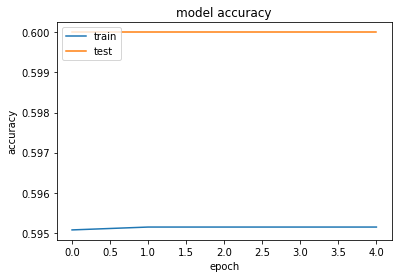

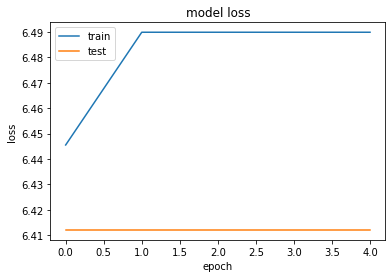

In [15]:
print(history.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate([x_test_title, x_test_text], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 6.489901295974372
Test accuracy: 0.5951463240585014


In [32]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH_TEXT,), dtype='int32')
embedded_sequences = embedding_layer_text(sequence_input)

for fsz in filter_sizes:
    text_1_conv = Conv1D(nb_filter=42,filter_length=fsz, activation='relu')(embedded_sequences)
    text_1_maxpool = MaxPooling1D(5)(text_1_conv)
    convs.append(text_1_maxpool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
dense_1 = Dense(128, activation='relu')(l_flat)
dropout_1 = Dropout(0.110)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.159)(dense_2)
dense_3 = Dense(128, activation='relu')(dropout_2)
dropout_3 = Dropout(0.159)(dense_3)
dense_out = Dense(2, activation='softmax')(dropout_3)

model_extended_2 = Model(sequence_input, dense_out)

# gradient descent
sgd = SGD(lr=0.240, decay=1e-6, momentum=0.303, nesterov=True)
# configure the learning process of the model
#model_extended_2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model_extended_2.compile(loss='categorical_crossentropy',
             optimizer='adadelta',
            metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model_extended_2.summary()
history_extended_2 = model_extended_2.fit(x_train_text, y_train, validation_data=(x_val_text, y_val),
          epochs=5, batch_size=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=4)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=5)`
  


Fitting a more complex convolutional neural network model
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1606)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1606, 100)    14067500    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 1604, 42)     12642       embedding_2[6][0]                
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 1603, 42)     16842       embedding_2[6][0]                
__________________________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


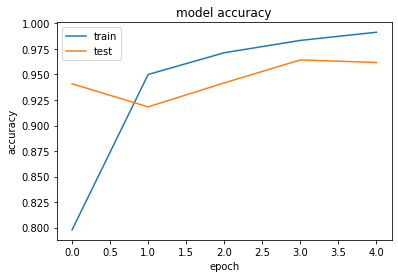

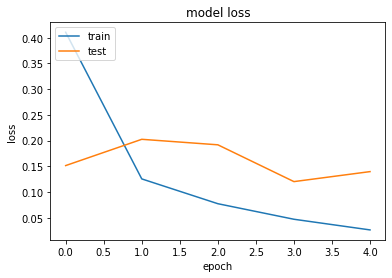

In [33]:
print(history_extended_2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history_extended_2.history['acc'])
plt.plot(history_extended_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_extended_2.history['loss'])
plt.plot(history_extended_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
score = model_extended_2.evaluate(x_test_text, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0098768492394807
Test accuracy: 0.9971448965024983
